In [2]:
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cdo
from scipy.spatial import KDTree

In [70]:
#defining function for RMSE

def rmse(obs, pred):
    actual_values = np.array(obs)
    predicted_values = np.array(pred)
    
    squared_errors = (obs - pred) ** 2
    
    mse = np.mean(squared_errors)
    
    rmse = np.sqrt(mse)
    
    return rmse


SYNOP are stations measurements, TEMP radiosondes and dropsondes, AIREP aircrafts, PILOT ballon observations, DRIBU are buoys
d[5,:] are my runs, d[0,:] Ariannas

## Global Verification 

In [4]:
#reading in data

urb_00_synop = xr.open_dataset('../pickle_files/testurban_run2022061500SYNOP.nc')
urb_12_synop = xr.open_dataset('../pickle_files/testurban_run2022061512SYNOP.nc')

opr_00_synop = xr.open_dataset('../pickle_files/testoperational_run2022061500SYNOP.nc')
opr_12_synop = xr.open_dataset('../pickle_files/testoperational_run2022061512SYNOP.nc')

urb_00_pilot = xr.open_dataset('../pickle_files/testurban_run2022061500PILOT.nc')
urb_12_pilot = xr.open_dataset('../pickle_files/testurban_run2022061512PILOT.nc')

opr_00_pilot = xr.open_dataset('../pickle_files/testoperational_run2022061500PILOT.nc')
opr_12_pilot = xr.open_dataset('../pickle_files/testoperational_run2022061512PILOT.nc')

urb_00_temp = xr.open_dataset('../pickle_files/testurban_run2022061500TEMP.nc')
urb_12_temp = xr.open_dataset('../pickle_files/testurban_run2022061512TEMP.nc')

opr_00_temp = xr.open_dataset('../pickle_files/testoperational_run2022061500TEMP.nc')
opr_12_temp = xr.open_dataset('../pickle_files/testoperational_run2022061512TEMP.nc')



/srv/conda3/envs/py3-general/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
opr_12_pilot.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [6]:
opr_12_temp.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [7]:
#bug check, see if files are different from each other

urb_00_synop_modified = urb_00_synop.copy()
opr_00_synop_modified = opr_00_synop.copy()

urb_00_synop_modified.attrs.pop('history', None)
opr_00_synop_modified.attrs.pop('history', None)

xr.testing.assert_identical(urb_00_synop_modified, opr_00_synop_modified)
print('The datasets are equal, excluding history')

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   veri_data         (d_veri, d_body) float32 0.841 -7.325 ... 57.95 0.8013
    longname: modelled quantity (as indicated by veri_ens_member)
R   veri_data         (d_veri, d_body) float32 0.841 -7.325 ... 57.93 0.8013
    longname: modelled quantity (as indicated by veri_ens_member)


In [8]:
#same bug check

urb_12_pilot_modified = urb_12_pilot.copy()
opr_12_pilot_modified = opr_12_pilot.copy()

urb_12_pilot_modified.attrs.pop('history', None)
opr_12_pilot_modified.attrs.pop('history', None)

xr.testing.assert_identical(urb_12_pilot_modified, opr_12_pilot_modified)
print('The datasets are equal, excluding history')

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   veri_data         (d_veri, d_body) float32 -2.984 0.9247 ... 24.49 4.289
    longname: modelled quantity (as indicated by veri_ens_member)
R   veri_data         (d_veri, d_body) float32 -2.984 0.9247 ... 24.6 4.298
    longname: modelled quantity (as indicated by veri_ens_member)


## Global Verification

In [9]:
#set the style

sns.set_style('whitegrid')

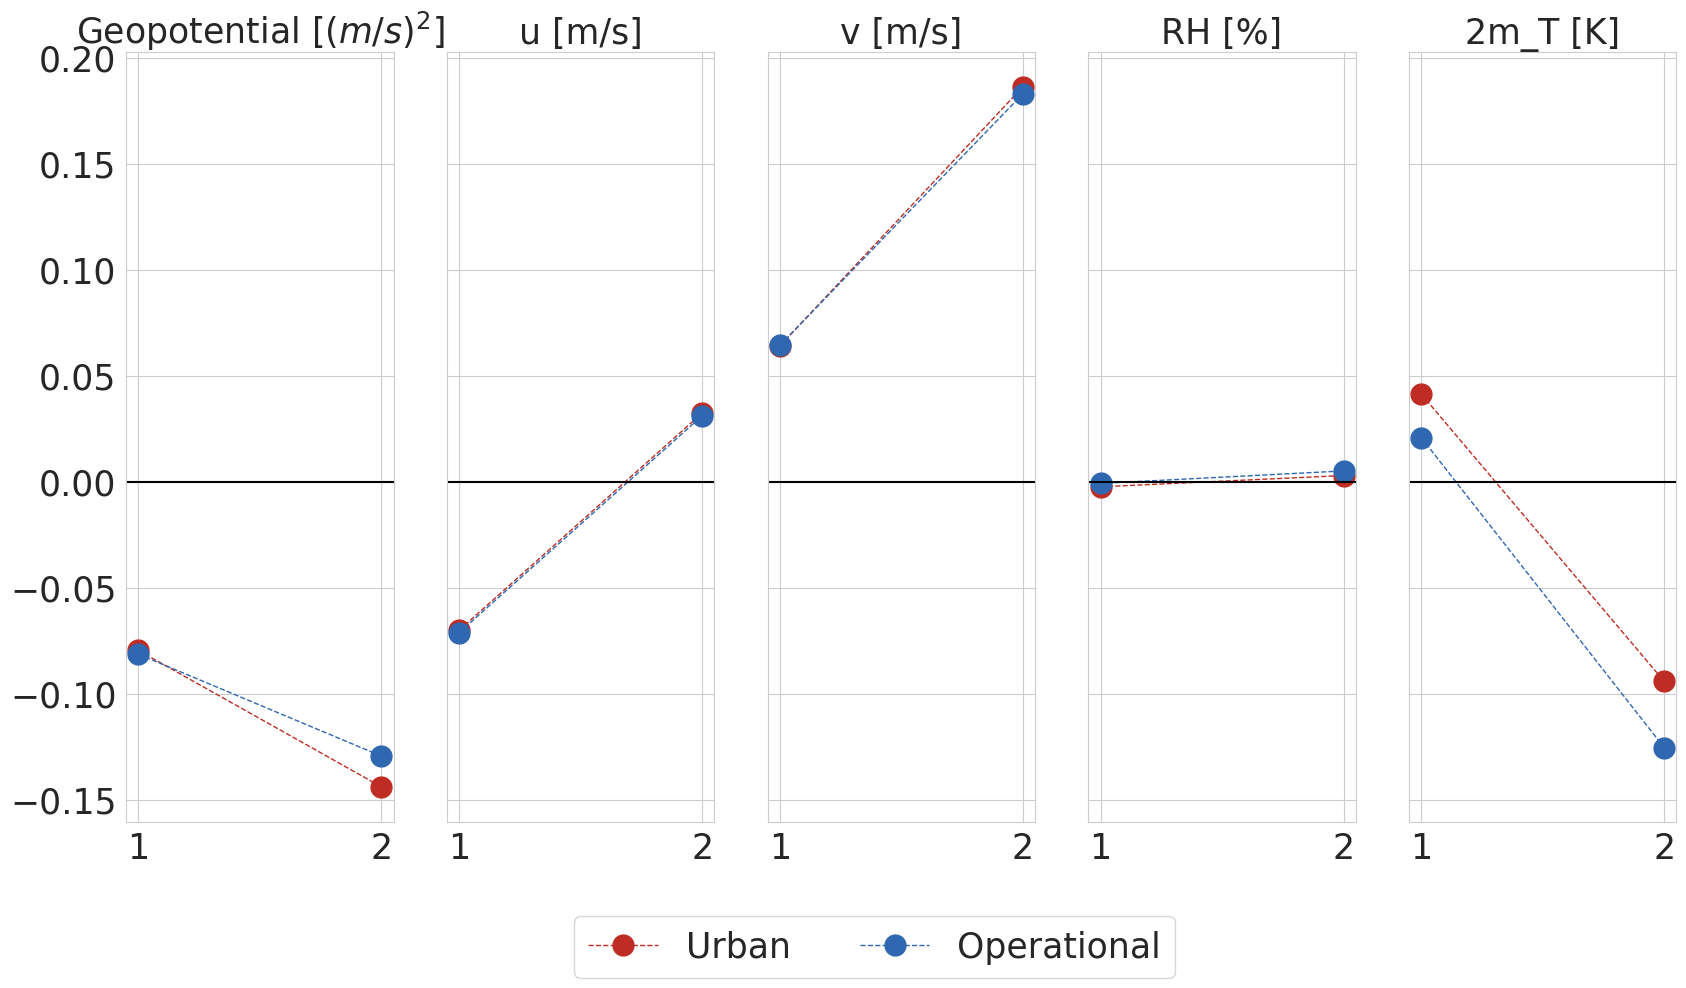

In [34]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential [$(m/s)^2$]', 'u [m/s]', 'v [m/s]', 'RH [%]', '2m_T [K]']
#y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_synop,
    'urban_00h': urb_00_synop,
    'operational_12h': opr_12_synop,
    'urban_12h': urb_12_synop,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15,  color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_00_3hlt, opr_12_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational \n (3h lead time)')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
#    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

#ax[-1].legend(loc='upper right', bbox_to_anchor=(0, -.5))
ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -0.1), ncol=2)
ax[0].set

plt.savefig('../plots_2024/verification/verification_global_SYNOP_2022.jpeg', dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()


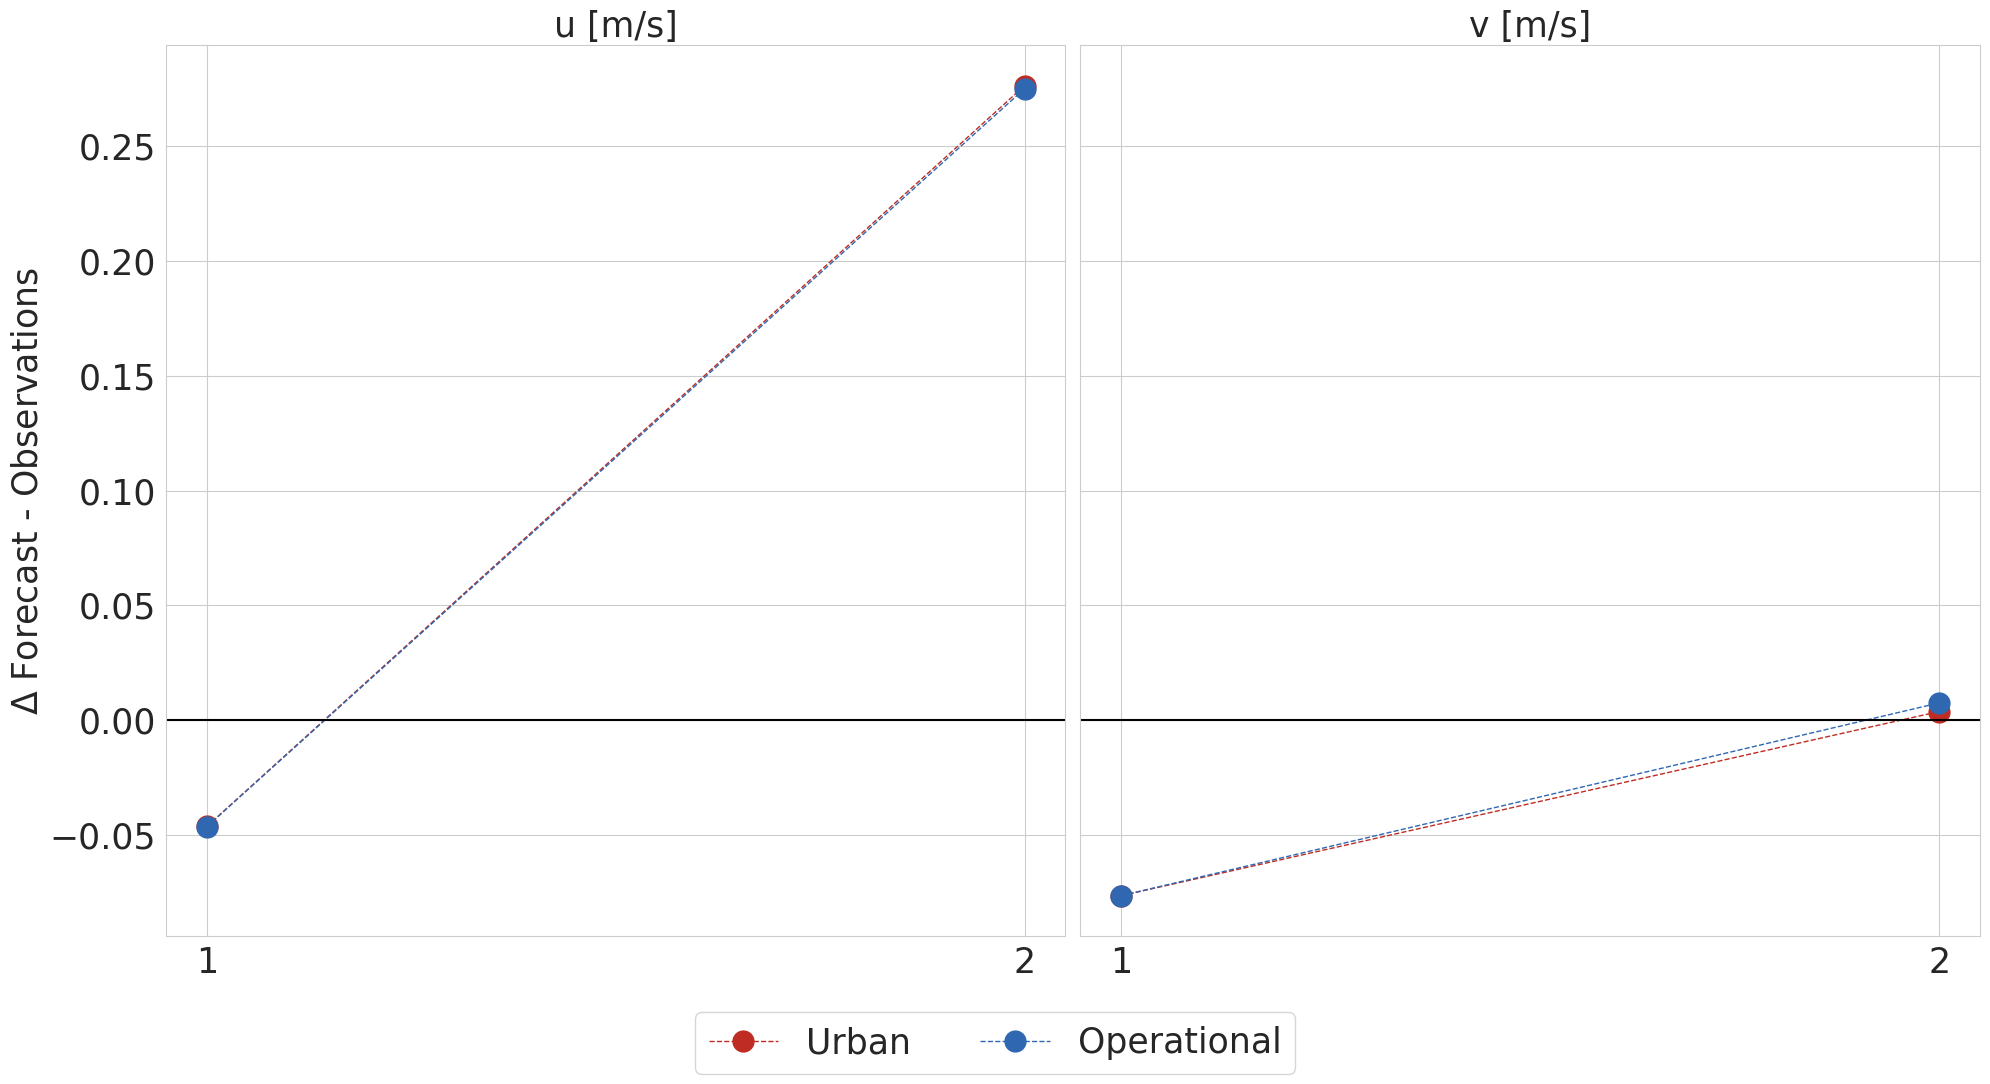

In [39]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u [m/s]', 'v [m/s]']
#y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot,
    'urban_00h': urb_00_pilot,
    'operational_12h': opr_12_pilot,
    'urban_12h': urb_12_pilot,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
 #   ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
#ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=2)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)


plt.tight_layout()
plt.savefig('../plots_2024/verification/verification_global_PILOT_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [71]:
np.unique(opr_00_temp.varno)

array([ 1.,  2.,  3.,  4., 29.], dtype=float32)

/tmp/ipykernel_2347203/1458432577.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


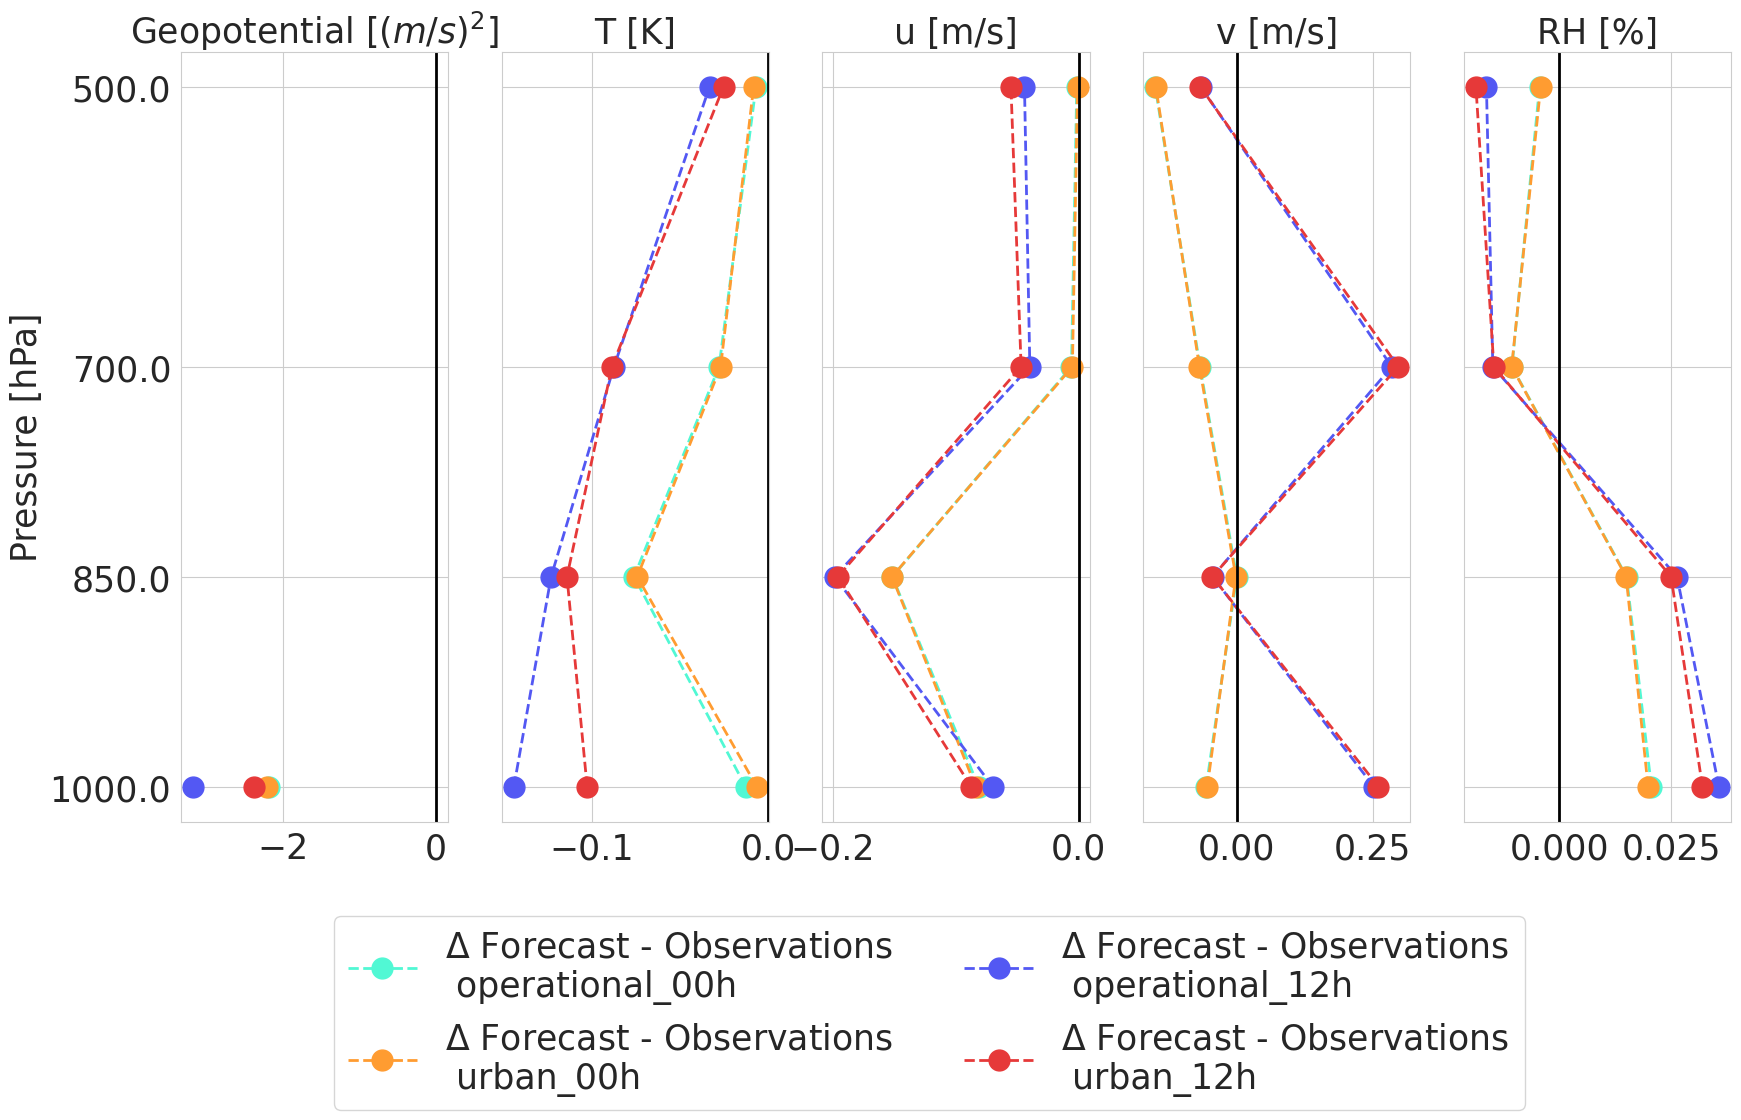

In [67]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential [$(m/s)^2$]', 'T [K]', 'u [m/s]', 'v [m/s]', 'RH [%]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp,
    'urban_00h': urb_00_temp,
}

datasets_12 = {
    'operational_12h': opr_12_temp,
    'urban_12h': urb_12_temp,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_global_TEMP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


## European Verification

xr.sel would be a more elegant way to slice the data, but it doesn't work, since lat lon are non-indexed multidimensional coordinates. It is discussed here
https://github.com/pydata/xarray/issues/2028

In [15]:
#filter european domain by where command with lon lat valules

urb_00_pilot_europe = urb_00_pilot.where((urb_00_pilot.lat >= 20) & (urb_00_pilot.lat <= 80) & (urb_00_pilot.lon >= -10) & (urb_00_pilot.lon <= 30), drop=True)
urb_12_pilot_europe = urb_12_pilot.where((urb_12_pilot.lat >= 20) & (urb_12_pilot.lat <= 80) & (urb_12_pilot.lon >= -10) & (urb_12_pilot.lon <= 30), drop=True)

opr_00_pilot_europe = opr_00_pilot.where((opr_00_pilot.lat >= 20) & (opr_00_pilot.lat <= 80) & (opr_00_pilot.lon >= -10) & (opr_00_pilot.lon <= 30), drop=True)
opr_12_pilot_europe = opr_12_pilot.where((opr_12_pilot.lat >= 20) & (opr_12_pilot.lat <= 80) & (opr_12_pilot.lon >= -10) & (opr_12_pilot.lon <= 30), drop=True)

urb_00_synop_europe = urb_00_synop.where((urb_00_synop.lat >= 20) & (urb_00_synop.lat <= 80) & (urb_00_synop.lon >= -10) & (urb_00_synop.lon <= 30), drop=True)
urb_12_synop_europe = urb_12_synop.where((urb_12_synop.lat >= 20) & (urb_12_synop.lat <= 80) & (urb_12_synop.lon >= -10) & (urb_12_synop.lon <= 30), drop=True)

opr_00_synop_europe = opr_00_synop.where((opr_00_synop.lat >= 20) & (opr_00_synop.lat <= 80) & (opr_00_synop.lon >= -10) & (opr_00_synop.lon <= 30), drop=True)
opr_12_synop_europe = opr_12_synop.where((opr_12_synop.lat >= 20) & (opr_12_synop.lat <= 80) & (opr_12_synop.lon >= -10) & (opr_12_synop.lon <= 30), drop=True)

urb_00_temp_europe = urb_00_temp.where((urb_00_temp.lat >= 20) & (urb_00_temp.lat <= 80) & (urb_00_temp.lon >= -10) & (urb_00_temp.lon <= 30), drop=True)
urb_12_temp_europe = urb_12_temp.where((urb_12_temp.lat >= 20) & (urb_12_temp.lat <= 80) & (urb_12_temp.lon >= -10) & (urb_12_temp.lon <= 30), drop=True)

opr_00_temp_europe = opr_00_temp.where((opr_00_temp.lat >= 20) & (opr_00_temp.lat <= 80) & (opr_00_temp.lon >= -10) & (opr_00_temp.lon <= 30), drop=True)
opr_12_temp_europe = opr_12_temp.where((opr_12_temp.lat >= 20) & (opr_12_temp.lat <= 80) & (opr_12_temp.lon >= -10) & (opr_12_temp.lon <= 30), drop=True)

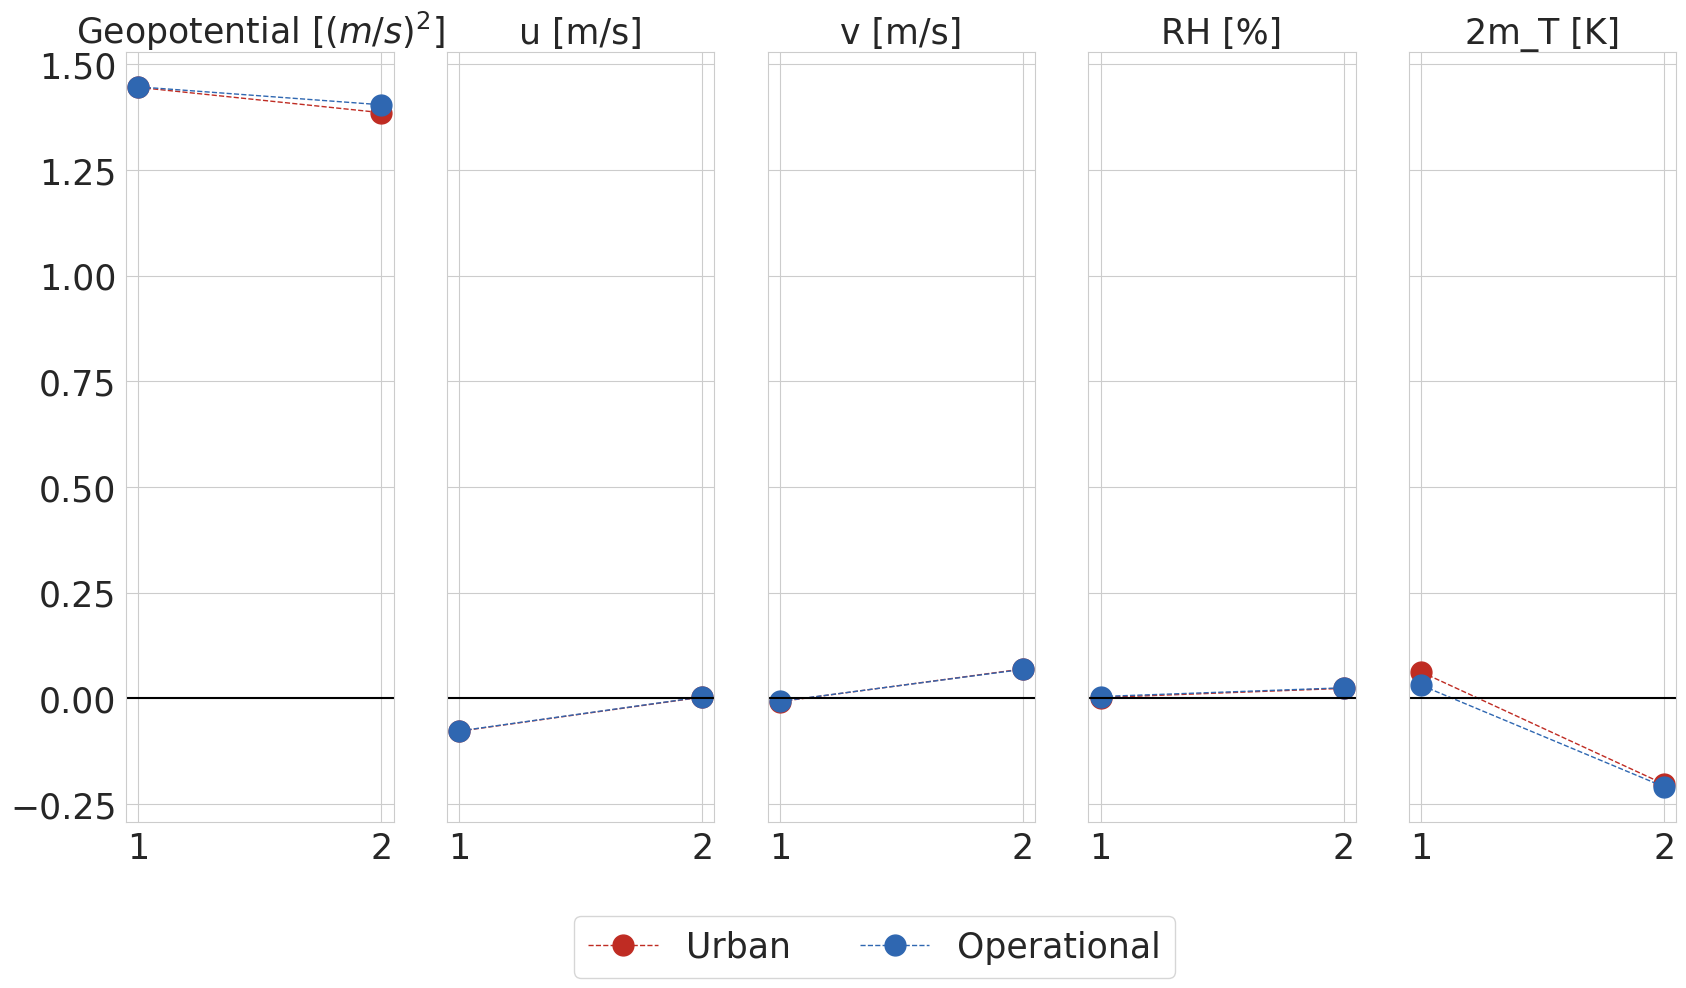

In [33]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential [$(m/s)^2$]', 'u [m/s]', 'v [m/s]', 'RH [%]', '2m_T [K]']
#y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_synop_europe,
    'urban_00h': urb_00_synop_europe,
    'operational_12h': opr_12_synop_europe,
    'urban_12h': urb_12_synop_europe,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_00_3hlt, opr_12_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational \n (3h lead time)')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
#    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

#ax[-1].legend(loc='upper right', bbox_to_anchor=(0, -.5))
ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -0.1), ncol=2)
ax[0].set

plt.savefig('../plots_2024/verification/verification_europe_SYNOP_2022.jpeg', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()


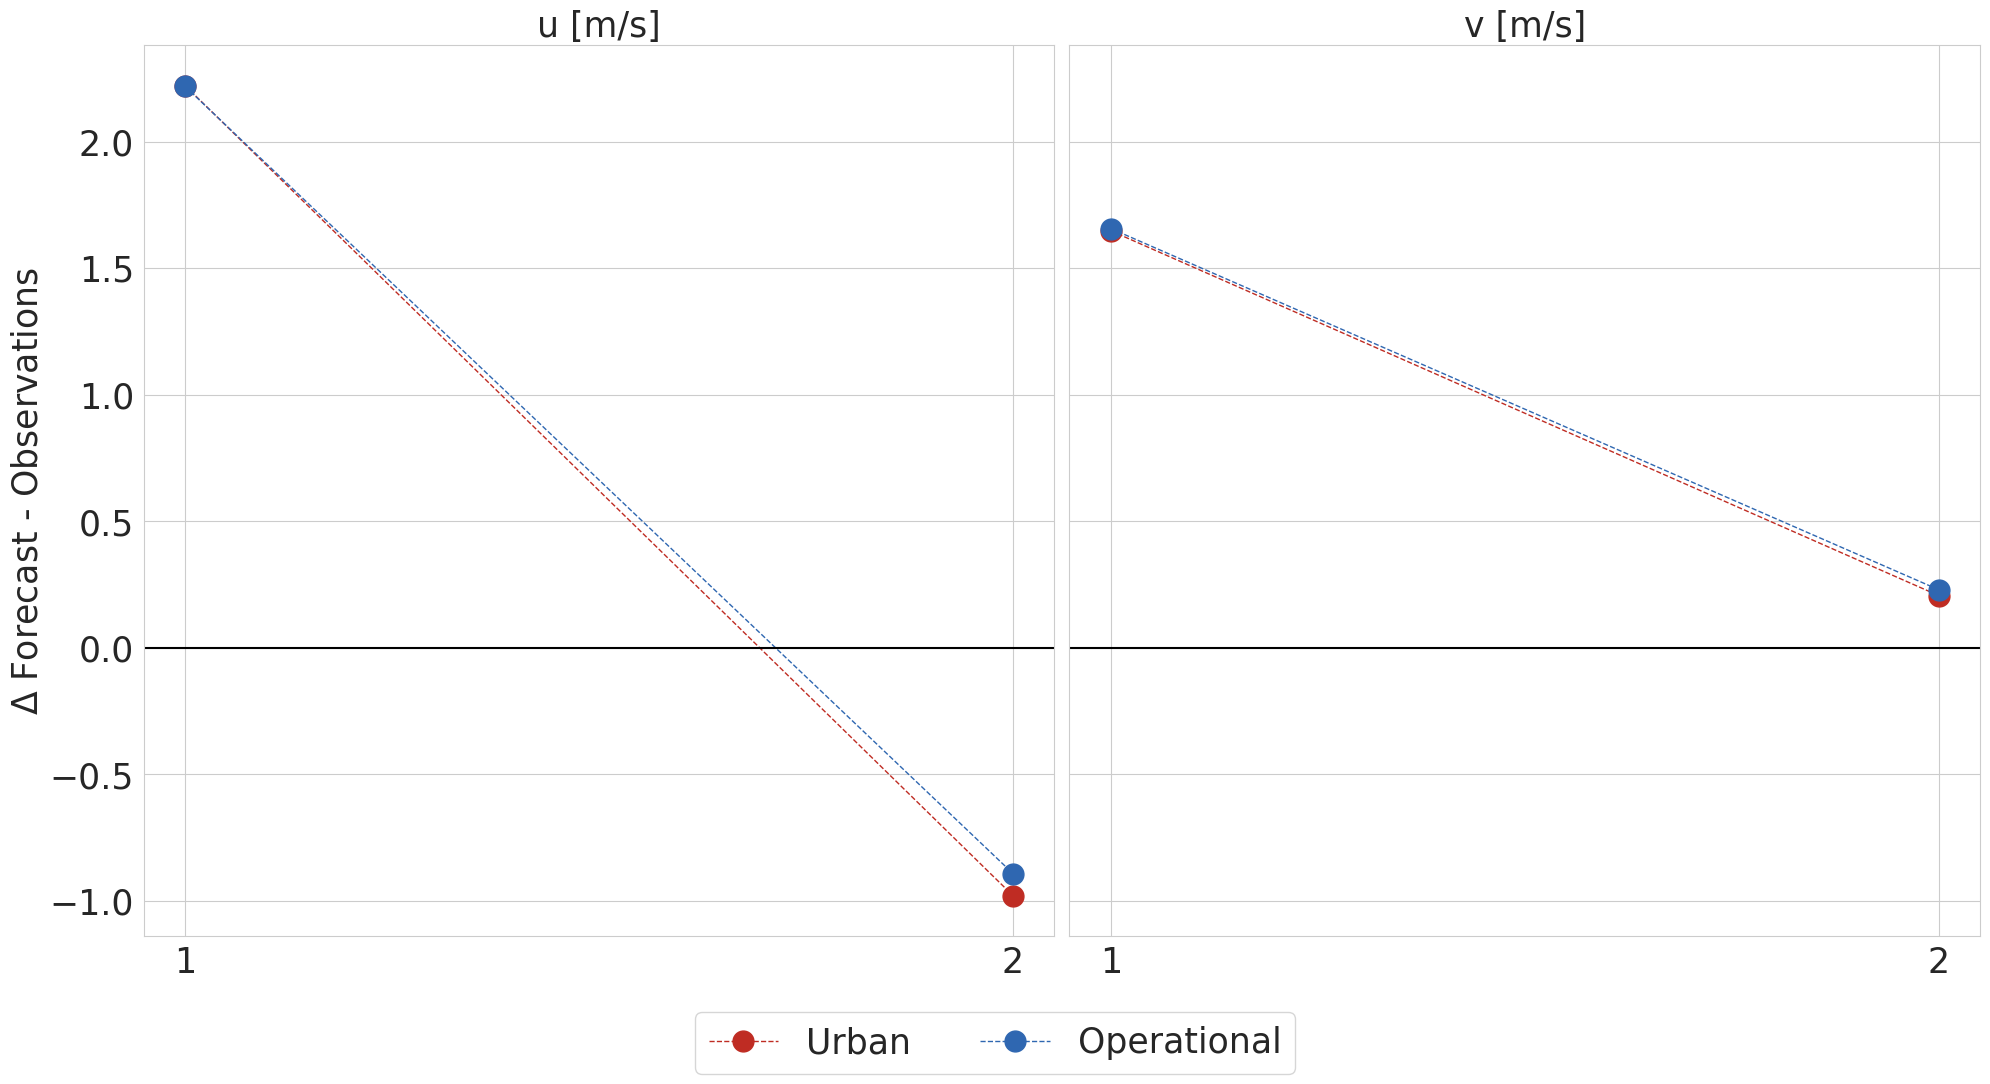

In [40]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u [m/s]', 'v [m/s]']
#y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot_europe,
    'urban_00h': urb_00_pilot_europe,
    'operational_12h': opr_12_pilot_europe,
    'urban_12h': urb_12_pilot_europe,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
 #   ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
#ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=2)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)


plt.tight_layout()
plt.savefig('../plots_2024/verification/verification_europe_PILOT_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


/tmp/ipykernel_2347203/2736693575.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


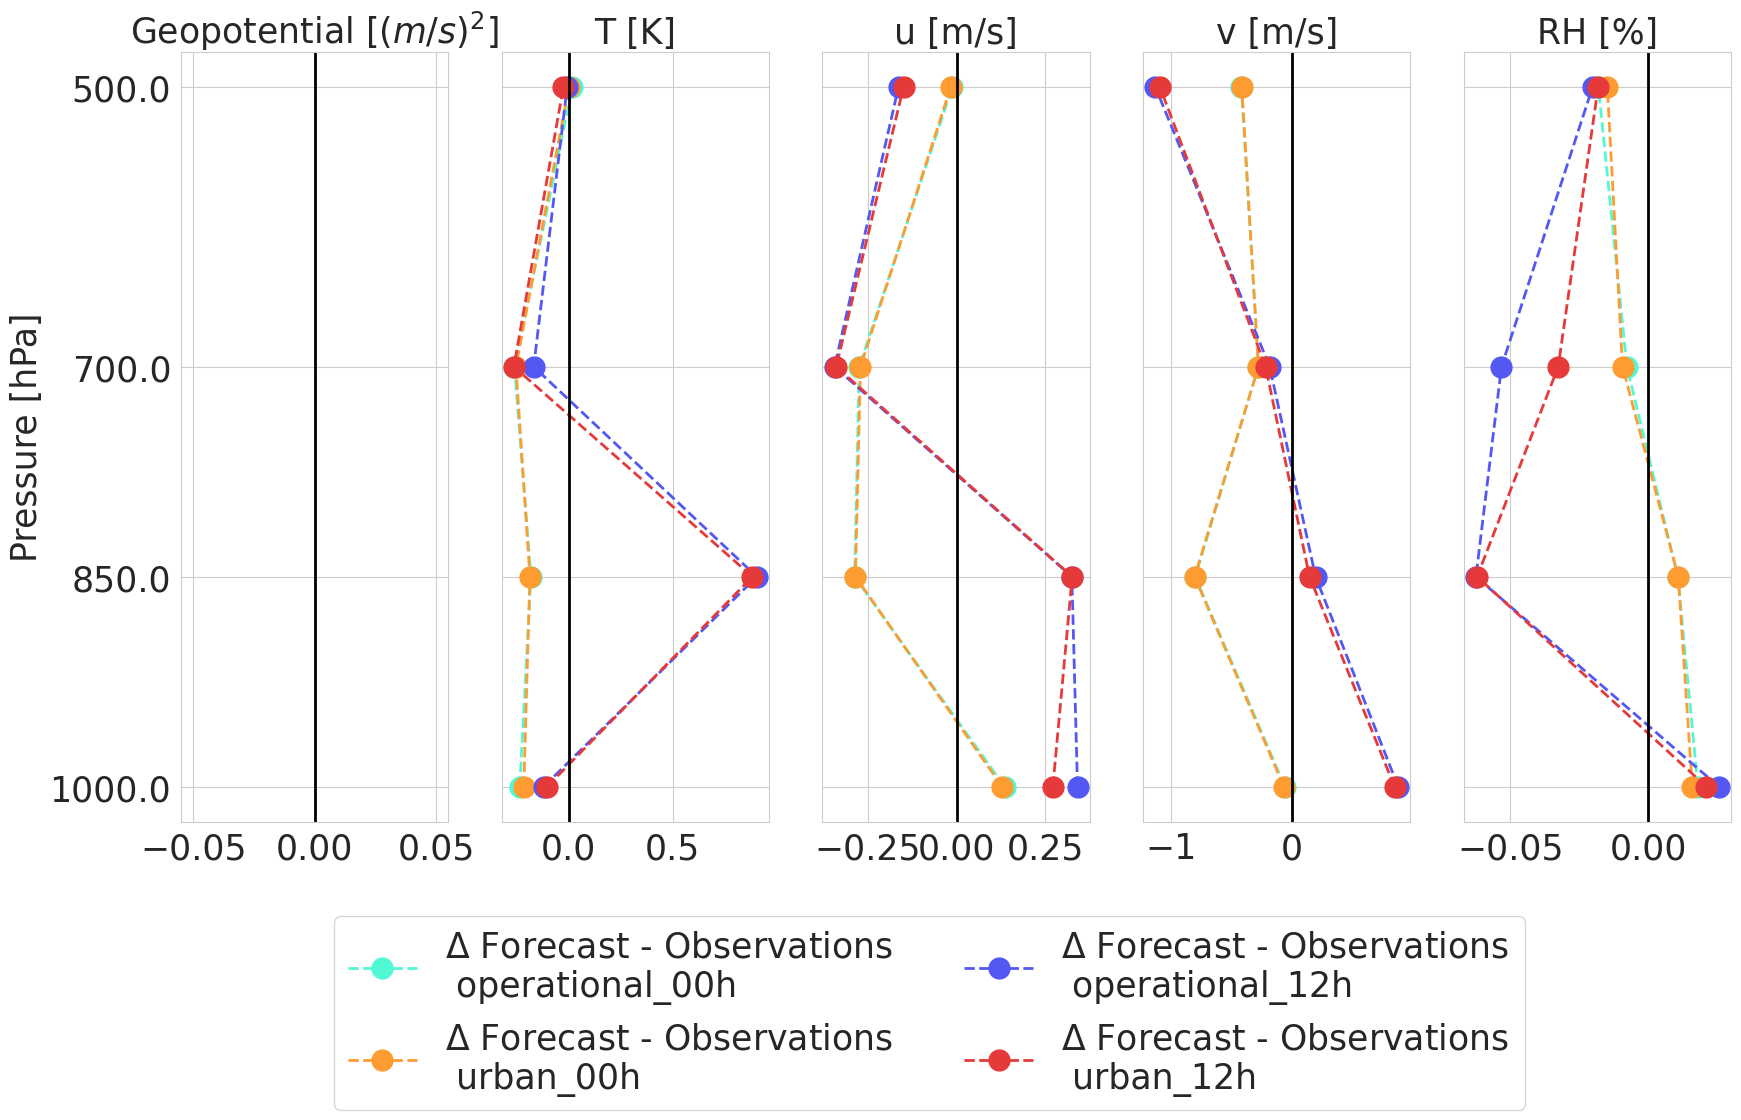

In [66]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential [$(m/s)^2$]', 'T [K]', 'u [m/s]', 'v [m/s]', 'RH [%]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp_europe,
    'urban_00h': urb_00_temp_europe,
}

datasets_12 = {
    'operational_12h': opr_12_temp_europe,
    'urban_12h': urb_12_temp_europe,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_europe_TEMP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


## Urban Grids Verification

In [22]:
#load dataset with lon lat values of cities, defined before

ds_det = xr.open_dataset('../det_data_all_2022/fc_DOM01_0001_NU_urban_grid.nc')

In [23]:
#select lon and lat values

ds_det["clat"] = np.degrees(ds_det["clat"])
ds_det["clon"] = np.degrees(ds_det["clon"])

In [41]:
#define K-D tree for the PILOT 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500PILOT.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [42]:
#initialize K-D tree
tree_icon = model_kdtree()
tree_icon.kdtree

In [43]:
# apply tree to lat lon values from cities given abvoe

indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [44]:
# select accordingly in verification files

urb_00_pilot_cities = urb_00_pilot.isel(d_body=indices_cities_ens)
opr_00_pilot_cities = opr_00_pilot.isel(d_body=indices_cities_ens)

In [45]:
#define K-D tree for the PYLOT 12 data 

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512PILOT.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [46]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [47]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [48]:
urb_12_pilot_cities = urb_12_pilot.isel(d_body=indices_cities_ens)
opr_12_pilot_cities = opr_12_pilot.isel(d_body=indices_cities_ens)

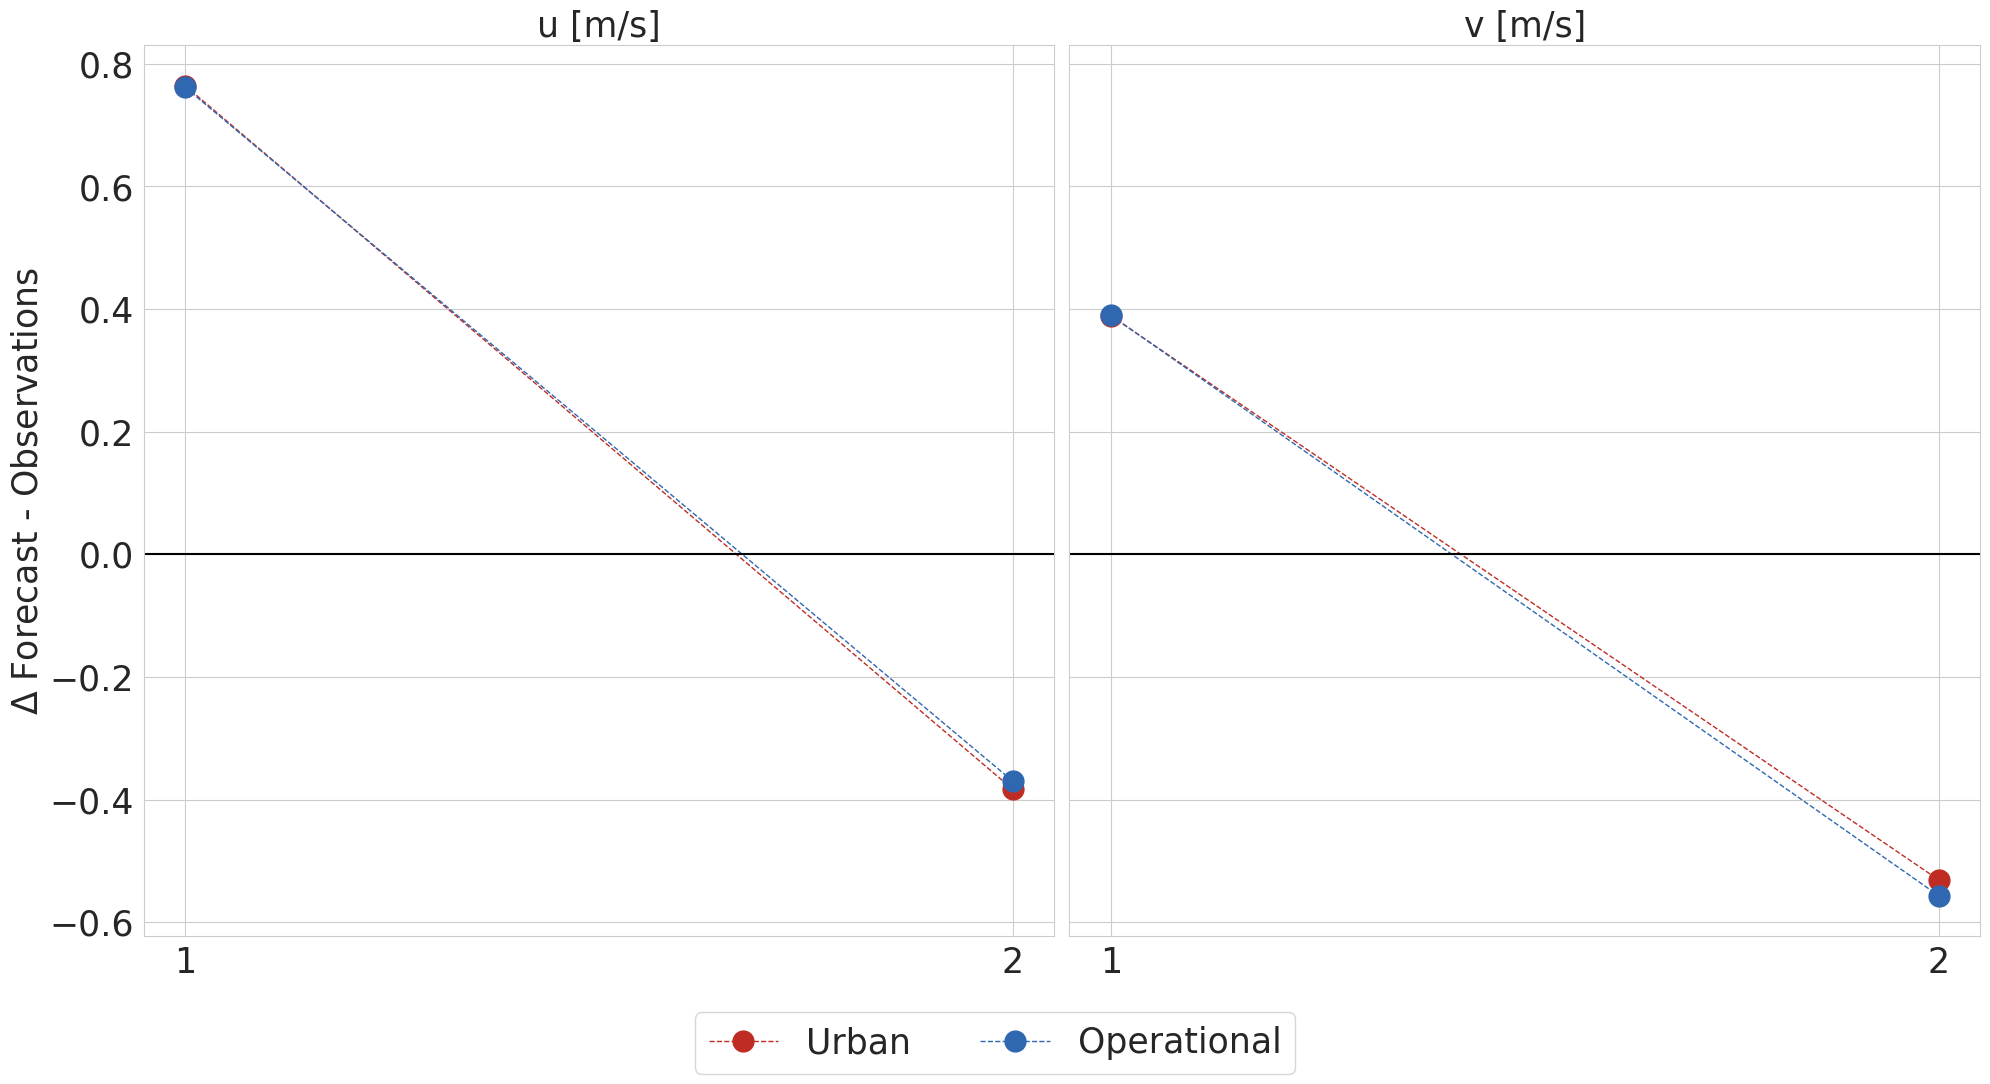

In [49]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u [m/s]', 'v [m/s]']
#y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot_cities,
    'urban_00h': urb_00_pilot_cities,
    'operational_12h': opr_12_pilot_cities,
    'urban_12h': urb_12_pilot_cities,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
 #   ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
#ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=2)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)


plt.tight_layout()
plt.savefig('../plots_2024/verification/verification_cities_PILOT_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
#define K-D tree for the SYNOP 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500SYNOP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [19]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [24]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [25]:
urb_00_synop_cities = urb_00_synop.isel(d_body=indices_cities_ens)
opr_00_synop_cities = opr_00_synop.isel(d_body=indices_cities_ens)

In [26]:
#define K-D tree for the SYNOP 12 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512SYNOP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [27]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [28]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [29]:
urb_12_synop_cities = urb_12_synop.isel(d_body=indices_cities_ens)
opr_12_synop_cities = opr_12_synop.isel(d_body=indices_cities_ens)

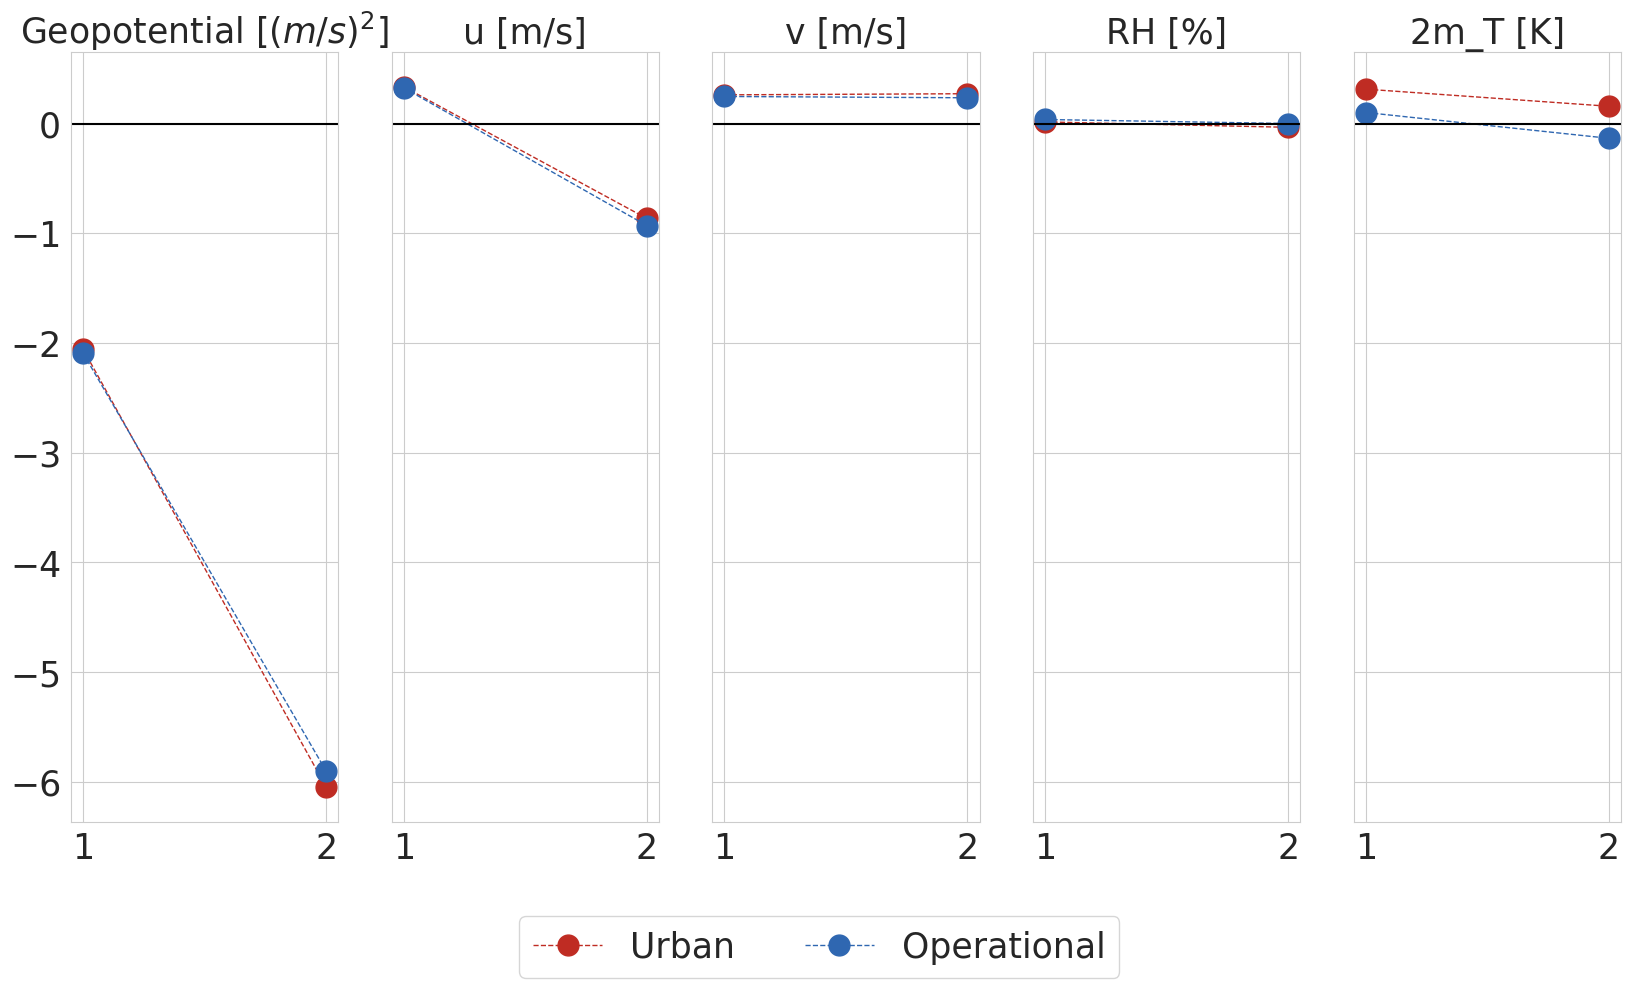

In [32]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential [$(m/s)^2$]', 'u [m/s]', 'v [m/s]', 'RH [%]', '2m_T [K]']
#y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_synop_cities,
    'urban_00h': urb_00_synop_cities,
    'operational_12h': opr_12_synop_cities,
    'urban_12h': urb_12_synop_cities,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_00_3hlt, opr_12_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational \n (3h lead time)')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
#    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

#ax[-1].legend(loc='upper right', bbox_to_anchor=(0, -.5))
ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -0.1), ncol=2)
ax[0].set

plt.savefig('../plots_2024/verification/verification_cities_SYNOP_2022.jpeg', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()


In [58]:
#define K-D tree for the TEMP 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500TEMP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [59]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [60]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [61]:
urb_00_temp_cities = urb_00_temp.isel(d_body=indices_cities_ens)
opr_00_temp_cities = opr_00_temp.isel(d_body=indices_cities_ens)

In [62]:
#define K-D tree for the TEMP 12 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512TEMP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [63]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [64]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [65]:
urb_12_temp_cities = urb_12_temp.isel(d_body=indices_cities_ens)
opr_12_temp_cities = opr_12_temp.isel(d_body=indices_cities_ens)

/tmp/ipykernel_2347203/3598715659.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


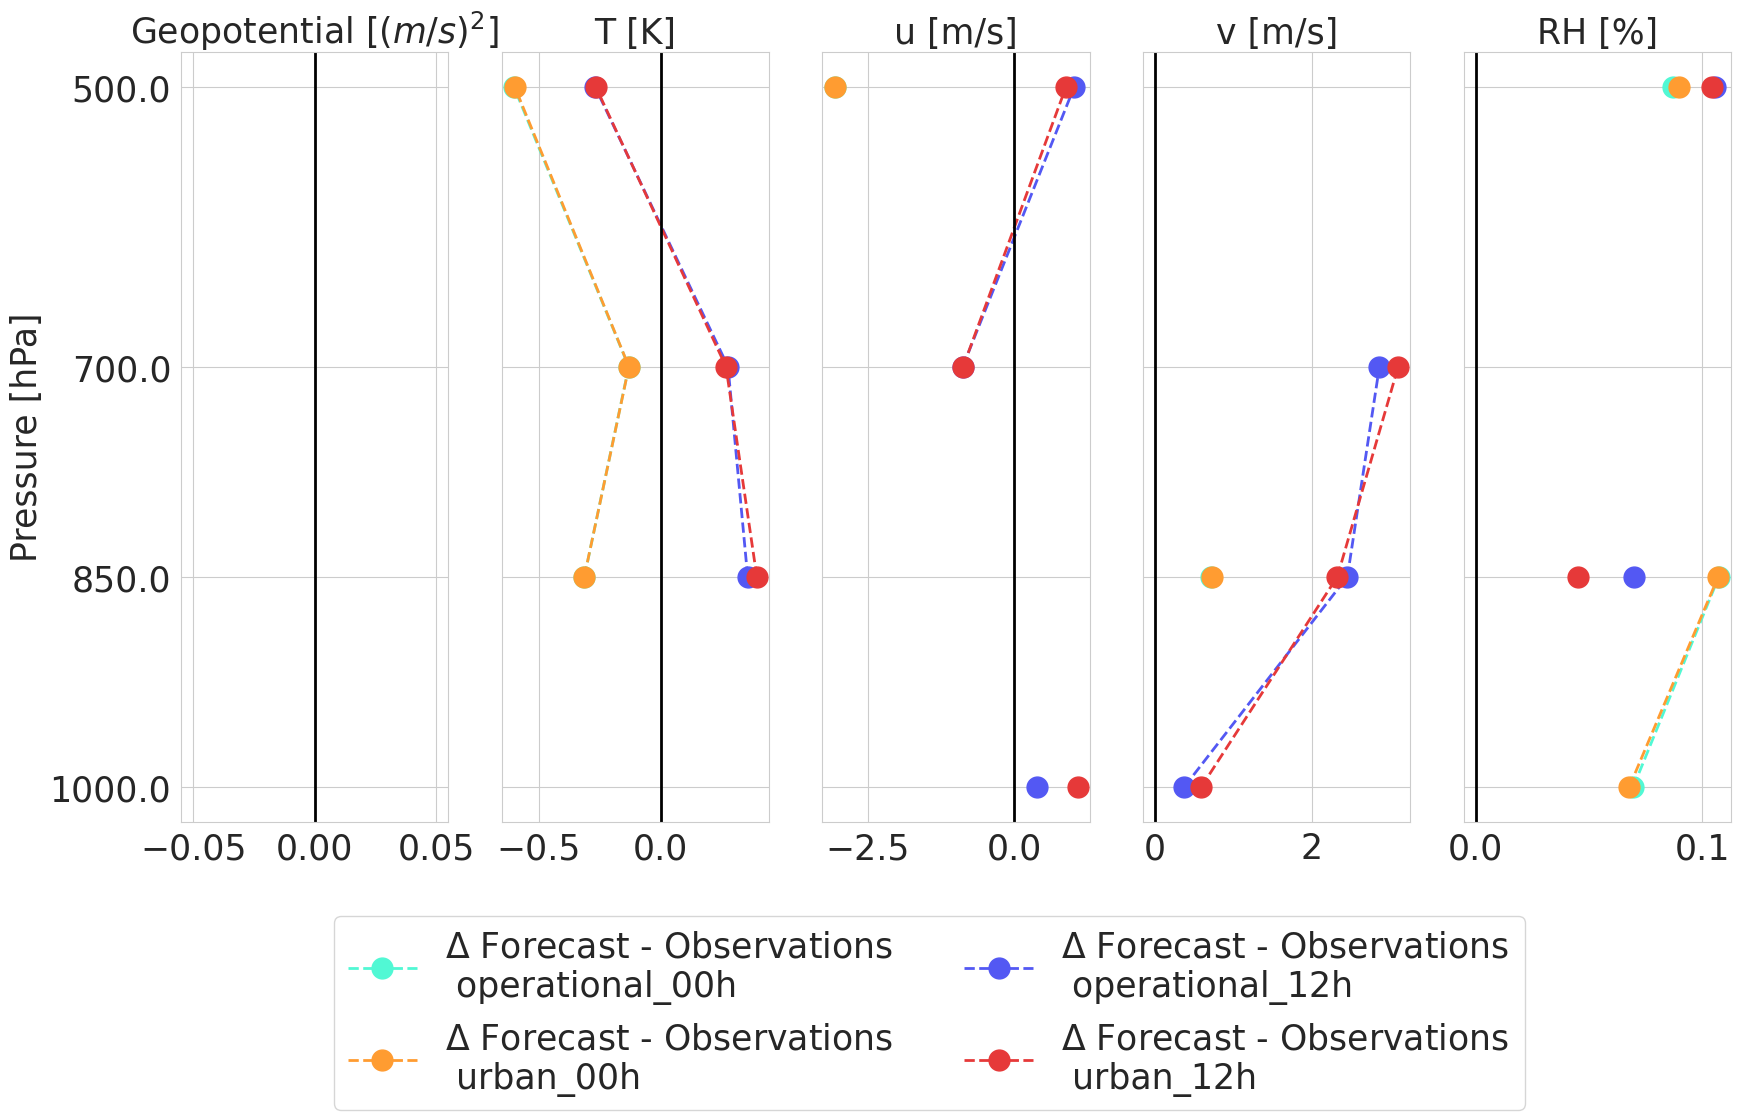

In [68]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential [$(m/s)^2$]', 'T [K]', 'u [m/s]', 'v [m/s]', 'RH [%]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp_cities,
    'urban_00h': urb_00_temp_cities,
}

datasets_12 = {
    'operational_12h': opr_12_temp_cities,
    'urban_12h': urb_12_temp_cities,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_cities_TEMP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


### RMSE analysis

In [130]:
#RMSE on temperature at 1000 hPa, TEMP

variables_00_urb = [urb_00_temp, urb_00_temp_europe, urb_00_temp_cities]
variables_12_urb = [urb_12_temp, urb_12_temp_europe, urb_12_temp_cities]

variables_00_opr = [opr_00_temp, opr_00_temp_europe, opr_00_temp_cities]
variables_12_opr = [opr_12_temp, opr_12_temp_europe, opr_12_temp_cities]

rmse_urb_00_temp_T = []
rmse_urb_12_temp_T = []
rmse_opr_00_temp_T = []
rmse_opr_12_temp_T = []

for data in variables_00_urb:
    rmse_value = rmse(data.veri_data[6, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_urb_00_temp_T.append(rmse_value.values)

for data in variables_12_urb:
    rmse_value = rmse(data.veri_data[5, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_urb_12_temp_T.append(rmse_value.values)

for data in variables_00_opr:
    rmse_value = rmse(data.veri_data[6, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_opr_00_temp_T.append(rmse_value.values)

for data in variables_12_opr:
    rmse_value = rmse(data.veri_data[5, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_opr_12_temp_T.append(rmse_value.values)

In [131]:
print('RSME OPR 00 global:', np.round(rmse_opr_00_temp_T[0], 3),
      'RMSE URB 00 global:', np.round(rmse_urb_00_temp_T[0], 3),
      'RSME OPR 12 global:', np.round(rmse_opr_12_temp_T[0], 3),
      'RSME URB 12 global:', np.round(rmse_urb_12_temp_T[0], 3))

print('RSME OPR 00 europe:', np.round(rmse_opr_00_temp_T[1], 3),
      'RMSE URB 00 europe:', np.round(rmse_urb_00_temp_T[1], 3),
      'RSME OPR 12 europe:', np.round(rmse_opr_12_temp_T[1], 3),
      'RSME URB 12 europe:', np.round(rmse_urb_12_temp_T[1], 3))

print('RSME OPR 00 cities:', np.round(rmse_opr_00_temp_T[2], 3),
      'RMSE URB 00 cities:', np.round(rmse_urb_00_temp_T[2], 3),
      'RSME OPR 12 cities:', np.round(rmse_opr_12_temp_T[2], 3),
      'RSME URB 12 cities:', np.round(rmse_urb_12_temp_T[2], 3))


RSME OPR 00 global: 0.013 RMSE URB 00 global: 0.006 RSME OPR 12 global: 0.144 RSME URB 12 global: 0.103
RSME OPR 00 europe: 0.234 RMSE URB 00 europe: 0.215 RSME OPR 12 europe: 0.12 RSME URB 12 europe: 0.103
RSME OPR 00 cities: nan RMSE URB 00 cities: nan RSME OPR 12 cities: nan RSME URB 12 cities: nan


In [139]:
#RMSE on temperature at 1000 hPa, SNYOP

variables_00_urb = [urb_00_synop, urb_00_synop_europe, urb_00_synop_cities]
variables_12_urb = [urb_12_synop, urb_12_synop_europe, urb_12_synop_cities]

variables_00_opr = [opr_00_synop, opr_00_synop_europe, opr_00_synop_cities]
variables_12_opr = [opr_12_synop, opr_12_synop_europe, opr_12_synop_cities]

rmse_urb_00_synop_2mT = []
rmse_urb_12_synop_2mT = []
rmse_opr_00_synop_2mT = []
rmse_opr_12_synop_2mT = []

for data in variables_00_urb:
    rmse_value = rmse(data.veri_data[6, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_urb_00_synop_2mT.append(rmse_value.values)

for data in variables_12_urb:
    rmse(data.veri_data[5, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_urb_12_synop_2mT.append(rmse_value.values)

for data in variables_00_opr:
    rmse_value = rmse(data.veri_data[6, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_opr_00_synop_2mT.append(rmse_value.values)

for data in variables_12_opr:
    rmse_value = rmse(data.veri_data[5, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_opr_12_synop_2mT.append(rmse_value.values)

In [140]:
print('RSME OPR 00 global:', np.round(rmse_opr_00_synop_2mT[0], 3),
      'RMSE URB 00 global:', np.round(rmse_urb_00_synop_2mT[0], 3),
      'RSME OPR 12 global:', np.round(rmse_opr_12_synop_2mT[0], 3),
      'RSME URB 12 global:', np.round(rmse_urb_12_synop_2mT[0], 3))

print('RSME OPR 00 europe:', np.round(rmse_opr_00_synop_2mT[1], 3),
      'RMSE URB 00 europe:', np.round(rmse_urb_00_synop_2mT[1], 3),
      'RSME OPR 12 europe:', np.round(rmse_opr_12_synop_2mT[1], 3),
      'RSME URB 12 europe:', np.round(rmse_urb_12_synop_2mT[1], 3))

print('RSME OPR 00 cities:', np.round(rmse_opr_00_synop_2mT[2], 3),
      'RMSE URB 00 cities:', np.round(rmse_urb_00_synop_2mT[2], 3),
      'RSME OPR 12 cities:', np.round(rmse_opr_12_synop_2mT[2], 3),
      'RSME URB 12 cities:', np.round(rmse_urb_12_synop_2mT[2], 3))


RSME OPR 00 global: 0.021 RMSE URB 00 global: 0.041 RSME OPR 12 global: 0.125 RSME URB 12 global: 0.314
RSME OPR 00 europe: 0.031 RMSE URB 00 europe: 0.062 RSME OPR 12 europe: 0.21 RSME URB 12 europe: 0.314
RSME OPR 00 cities: 0.101 RMSE URB 00 cities: 0.314 RSME OPR 12 cities: 0.134 RSME URB 12 cities: 0.314
